In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing

# Load newest Google stock data from Yahoo Finance

In [2]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('GOOG','yahoo',start,end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-20,1227.140015,1196.170044,1197.349976,1223.969971,2227400.0,1223.969971
2019-03-21,1231.790039,1213.150024,1216.000000,1231.540039,1204000.0,1231.540039
2019-03-22,1230.000000,1202.824951,1226.319946,1205.500000,1714200.0,1205.500000
2019-03-25,1206.397949,1187.040039,1196.930054,1193.000000,1496800.0,1193.000000
2019-03-26,1202.829956,1176.719971,1198.530029,1184.619995,1898100.0,1184.619995


# Normalise and Prepozess the data like a boss^12

In [3]:
#normalise data
data_n = stock_data_preprocessing.normalise_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
2004-08-19,0.731812,3.0,0.543621,1.000000,0.996611,1.037074,0.956348,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-20,0.731813,4.0,0.277955,1.079430,1.006677,1.087104,1.001595,-0.722045,0.079430,0.006677,0.087104,0.001595
2004-08-23,0.731816,0.0,0.222226,1.090293,1.103747,1.130955,1.086805,-0.794127,0.010064,0.022528,0.047733,0.006832
2004-08-24,0.731817,1.0,0.185600,1.045146,1.108631,1.112218,1.032190,-0.829770,-0.041408,0.016819,0.020110,-0.053291
2004-08-25,0.731818,2.0,0.111847,1.056408,1.046043,1.076340,1.035280,-0.892984,0.010775,0.000858,0.029846,-0.009440


# 1,2,3 Plot Line!

/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


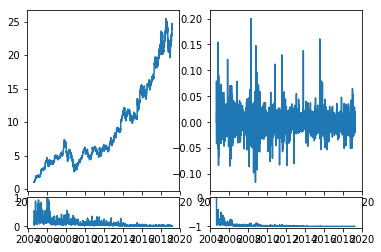

In [6]:
stock_data_preprocessing.stock_plot((data_n,))

# Pickup the Data

In [7]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


# unroll it

In [8]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3123, 50, 12)
y_train (3123,)
x_test (450, 50, 12)
y_test (450,)


# Go! (with Python 3.5, Keras 1.2.2 and Tensorflow 1.0, better on AWS)

In [9]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [10]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=x_train.shape[-1],
    output_shape=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 12), units=50)`
  import sys


compilation time : 0.023584842681884766


/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [11]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epoch=350,
    validation_split=0.05)

/Users/YTsBaCh/Applications/anaconda3/envs/env_zipline/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 2966 samples, validate on 157 samples
Epoch 1/350
2966/2966 [==============================] - 9s 3ms/step - loss: 0.0431 - val_loss: 0.9798
Epoch 2/350
2966/2966 [==============================] - 4s 1ms/step - loss: 1.0933 - val_loss: 0.0019
Epoch 3/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0128 - val_loss: 0.0032
Epoch 4/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0130 - val_loss: 0.0020
Epoch 5/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0123 - val_loss: 0.0018
Epoch 6/350
2966/2966 [==============================] - 4s 1ms/step - loss: 0.0120 - val_loss: 7.3322e-04
Epoch 7/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0119 - val_loss: 5.2529e-04
Epoch 8/350
2966/2966 [==============================] - 4s 1ms/step - loss: 0.0119 - val_loss: 5.4649e-04
Epoch 9/350
2966/2966 [==============================] - 4s 1ms/step - loss: 0.0111 - val_loss: 3.3840e-04
Epoch 10/3

2966/2966 [==============================] - 4s 1ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 80/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 81/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 82/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 83/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 84/350
2966/2966 [==============================] - 4s 1ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 85/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0023 - val_loss: 8.4456e-04
Epoch 86/350
2966/2966 [==============================] - 3s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 87/350
2966/2966 [==============================] - 4s 1ms/step - loss: 0.0022 - val_loss: 7.8574e-04
Epoch 88/350
2966/2966 [==============================] - 3s 1ms/step

Epoch 154/350
2966/2966 [==============================] - 3s 1ms/step - loss: 5.4487e-04 - val_loss: 1.0849e-04
Epoch 155/350
2966/2966 [==============================] - 3s 1ms/step - loss: 4.9622e-04 - val_loss: 8.6574e-05
Epoch 156/350
2966/2966 [==============================] - 4s 1ms/step - loss: 4.8467e-04 - val_loss: 9.0373e-05
Epoch 157/350
2966/2966 [==============================] - 4s 1ms/step - loss: 4.7004e-04 - val_loss: 8.6841e-05
Epoch 158/350
2966/2966 [==============================] - 4s 1ms/step - loss: 4.5604e-04 - val_loss: 8.7205e-05
Epoch 159/350
2966/2966 [==============================] - 3s 1ms/step - loss: 4.5903e-04 - val_loss: 8.9882e-05
Epoch 160/350
2966/2966 [==============================] - 4s 1ms/step - loss: 4.7258e-04 - val_loss: 8.6913e-05
Epoch 161/350
2966/2966 [==============================] - 4s 1ms/step - loss: 4.5498e-04 - val_loss: 9.0551e-05
Epoch 162/350
2966/2966 [==============================] - 3s 1ms/step - loss: 4.6950e-04 - val_

Epoch 227/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9045e-04 - val_loss: 8.4866e-05
Epoch 228/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9388e-04 - val_loss: 8.5012e-05
Epoch 229/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9396e-04 - val_loss: 8.4734e-05
Epoch 230/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9534e-04 - val_loss: 8.4954e-05
Epoch 231/350
2966/2966 [==============================] - 4s 1ms/step - loss: 3.9548e-04 - val_loss: 8.4647e-05
Epoch 232/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9149e-04 - val_loss: 8.4957e-05
Epoch 233/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.8999e-04 - val_loss: 8.4662e-05
Epoch 234/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.8861e-04 - val_loss: 8.6006e-05
Epoch 235/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9362e-04 - val_

Epoch 300/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9334e-04 - val_loss: 8.6362e-05
Epoch 301/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9311e-04 - val_loss: 8.7462e-05
Epoch 302/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.8842e-04 - val_loss: 8.5210e-05
Epoch 303/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.8836e-04 - val_loss: 8.7108e-05
Epoch 304/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9000e-04 - val_loss: 8.5554e-05
Epoch 305/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.8945e-04 - val_loss: 8.8314e-05
Epoch 306/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9135e-04 - val_loss: 8.7256e-05
Epoch 307/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9137e-04 - val_loss: 9.1021e-05
Epoch 308/350
2966/2966 [==============================] - 3s 1ms/step - loss: 3.9134e-04 - val_

# Same Model & some (~ x10) fewer Loss !!! :) 

yo


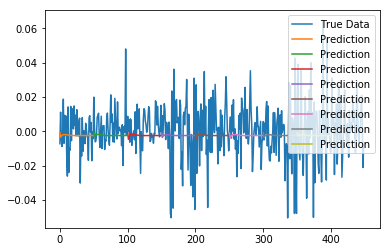

In [12]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)